# House price prediction using linear regression

We will use the boston housing dataset, which is available on Kaggle platform: https://www.kaggle.com/c/boston-housing/

In [162]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [163]:
# Hyperparameters
batch_size=64
learning_rate=0.0000005

In [164]:
# Other constants
DATASET_URL = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
DATA_FILENAME = "BostonHousing.csv"
TARGET_COLUMN = 'medv'
input_size=13
output_size=1

## Dataset & Data loaders

In [165]:
# Download the data
download_url(DATASET_URL, '.')
dataframe = pd.read_csv(DATA_FILENAME)
dataframe.head()

Using downloaded and verified file: ./BostonHousing.csv


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [166]:
# Convert from Pandas dataframe to numpy arrays
inputs = dataframe.drop('medv', axis=1).values
targets = dataframe[['medv']].values
inputs.shape, targets.shape

((506, 13), (506, 1))

In [167]:
inputs

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [168]:
targets[0: 10]

array([[24. ],
       [21.6],
       [34.7],
       [33.4],
       [36.2],
       [28.7],
       [22.9],
       [27.1],
       [16.5],
       [18.9]])

#Converting to the Pytorch dataset

In [183]:
# Convert to PyTorch dataset
dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))
train_ds, val_ds, test_ds = random_split(dataset, [406, 60, 40])

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)


## Model

Create a class for Boston Housing and we will call the class for its prediction

In [184]:
class HousingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)# input_size=13, output_size = 1

    def forward(self, xb):
        out = self.linear(xb)
        return out

    def training_step(self, batch):
        inputs, targets = batch
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return loss

    def validation_step(self, batch):
        inputs, targets = batch
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))


model = HousingModel() # calling our model

## Training

In [185]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = [] # save the track of validation loss
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

We will evaluate the model with validation dataset to check its performance

In [186]:
result = evaluate(model, val_loader)
result

{'val_loss': 160.61976623535156}

In [187]:
history = fit(5, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 78.3600
Epoch [1], val_loss: 77.0244
Epoch [2], val_loss: 74.4538
Epoch [3], val_loss: 72.6340
Epoch [4], val_loss: 71.5379


In [188]:
history1 = fit(50, 0.00000088, model, train_loader, val_loader)

Epoch [0], val_loss: 72.5546
Epoch [1], val_loss: 69.0622
Epoch [2], val_loss: 67.9363
Epoch [3], val_loss: 70.8935
Epoch [4], val_loss: 68.4098
Epoch [5], val_loss: 66.7011
Epoch [6], val_loss: 69.2646
Epoch [7], val_loss: 66.6062
Epoch [8], val_loss: 70.0035
Epoch [9], val_loss: 66.2504
Epoch [10], val_loss: 66.1880
Epoch [11], val_loss: 66.6872
Epoch [12], val_loss: 66.1633
Epoch [13], val_loss: 66.0343
Epoch [14], val_loss: 68.0746
Epoch [15], val_loss: 66.9252
Epoch [16], val_loss: 65.3321
Epoch [17], val_loss: 65.4510
Epoch [18], val_loss: 67.3906
Epoch [19], val_loss: 72.9062
Epoch [20], val_loss: 65.0229
Epoch [21], val_loss: 65.0343
Epoch [22], val_loss: 65.4802
Epoch [23], val_loss: 64.7992
Epoch [24], val_loss: 66.9127
Epoch [25], val_loss: 65.4975
Epoch [26], val_loss: 66.3016
Epoch [27], val_loss: 67.0765
Epoch [28], val_loss: 67.7475
Epoch [29], val_loss: 64.7838
Epoch [30], val_loss: 66.1041
Epoch [31], val_loss: 63.9686
Epoch [32], val_loss: 66.7570
Epoch [33], val_loss

In [189]:
history2 = fit(5, 0.00000088, model, train_loader, val_loader)

Epoch [0], val_loss: 63.6243
Epoch [1], val_loss: 64.4863
Epoch [2], val_loss: 63.7484
Epoch [3], val_loss: 63.7735
Epoch [4], val_loss: 64.3741


Plot the validation losses



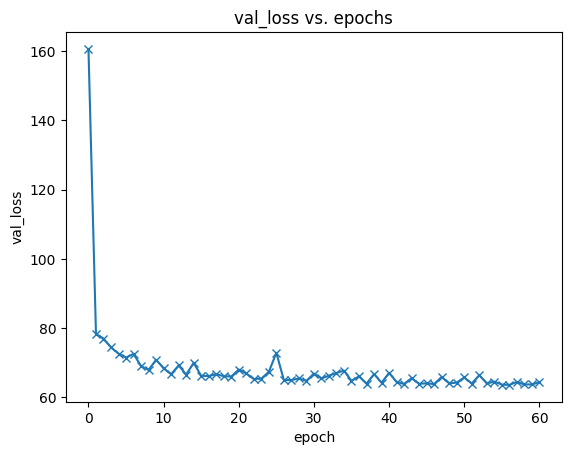

In [192]:
losses = [r['val_loss'] for r in [result] + history+history1+history2]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');

## Prediction

Function to predict the single output from single input

In [197]:
def predict_single(x, model):
    xb = x.unsqueeze(0)
    return model(x).item()

In [200]:
x, target = val_ds[53]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([5.5610e-02, 7.0000e+01, 2.2400e+00, 0.0000e+00, 4.0000e-01, 7.0410e+00,
        1.0000e+01, 7.8278e+00, 5.0000e+00, 3.5800e+02, 1.4800e+01, 3.7158e+02,
        4.7400e+00])
Target:  29.0
Prediction: 32.885684967041016


#### Our model is working well, because it is predicting the number near to target

## Save and upload

We will save the model and use the saved model parametrs later on.

In [105]:
torch.save(model.state_dict(), 'housing-linear.pth')

To download the saved model on google colab

In [201]:
from google.colab import files


model_path = 'housing-linear.pth'
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>